<a href="https://colab.research.google.com/github/mamoan/NOVA_DL_home_exercise/blob/main/1_data_tiling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1 - Data tiling 🗺️ --> ⬜⬜⬜ ...
## Objective: Going from orthomosaic to tiles

Deep learning models need smaller images and can not use an entire orthomosaic.

### Define tiling and reference parameters

In [ ]:
tile_size_m=10 # tile size in m
buffer_size_m=0 # tile buffer size_m (used to produce overlapping tiles)

In [ ]:
# define path to your own google drive
my_drive_path="/content/drive/MyDrive"
path_data=my_drive_path+"/NOVA_course_home_exercise/data"
input_ortho_path1=path_data+"/orthomosaics/test_data/krakstad_202304_sun.tif"
input_ortho_path2=path_data+"/orthomosaics/test_data/ortho_hobol_042222_mavic_sun.tif"
input_ortho_path3=path_data+"/orthomosaics/test_data/galbyveien_20230504_sun.tif"
input_ortho_path4=path_data+"/orthomosaics/test_data/braatan_40m_20230605_sun.tif"

### 1.1 Install and import required python libraries (not included in colab)

In [ ]:
# install required libraries (if running in a local conda environment then other libraries might need to be installed)
!pip install geopandas
!pip install rasterio
!pip install folium matplotlib mapclassify

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 13.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.4/16.4 MB 47.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.9/7.9 MB 63.3 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.3/21.3 MB 18.7 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
# general python packages
## general packages
import os, glob, shutil
from pathlib import Path
from datetime import datetime, timedelta
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# geospatial packages
from osgeo import gdal, ogr, osr
import geopandas as gpd
from shapely.geometry import Polygon
import rasterio as rio
import folium

# define path to where osgeo utils (gdal_retile.py) are stored
path_osgeo_utils= "/usr/local/lib/python3.10/dist-packages/osgeo_utils"

### 1.2 Mount google drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### 1.3 Load data

#### Define paths to available orthomosaics

In [ ]:
path_data=my_drive_path+"/NOVA_course_home_exercise/data/"
orthos = os.listdir(path_data+"/orthomosaics/test_data")

#### Load orthomosaic footprints (pre-create vector file)

In [ ]:
# define directory to where the drone acquisition geojson is stored
dir_drone_acquisitions=path_data+"map_data/drone_acquisitions.geojson"
dir_drone_acquisitions

'/content/drive/MyDrive/NOVA_course_home_exercise/data/map_data/drone_acquisitions.geojson'

In [ ]:
footprints= gpd.read_file(dir_drone_acquisitions)

In [ ]:
# Here you can get an overview of where the data are located
footprints.explore()

### 1.4 Tiling

In [ ]:
# get orthomosaic name
ortho_name1=os.path.splitext(os.path.basename(input_ortho_path1)) [0]
ortho_name1

ortho_name2=os.path.splitext(os.path.basename(input_ortho_path2)) [0]
ortho_name2

ortho_name3=os.path.splitext(os.path.basename(input_ortho_path3)) [0]
ortho_name3

ortho_name4=os.path.splitext(os.path.basename(input_ortho_path4)) [0]
ortho_name4

'braatan_40m_20230605_sun'

In [ ]:
path_data

'/content/drive/MyDrive/NOVA_course_home_exercise/data/'

Define and create an output directory to store the tiles

In [ ]:
output_tiles_dir1=path_data+"tiles/"+str(tile_size_m)+"m_"+ortho_name1
if not os.path.exists(output_tiles_dir1):
    os.makedirs(output_tiles_dir1)

output_tiles_dir1

output_tiles_dir2=path_data+"tiles/"+str(tile_size_m)+"m_"+ortho_name2
if not os.path.exists(output_tiles_dir2):
    os.makedirs(output_tiles_dir2)

output_tiles_dir2

output_tiles_dir3=path_data+"tiles/"+str(tile_size_m)+"m_"+ortho_name3
if not os.path.exists(output_tiles_dir3):
    os.makedirs(output_tiles_dir3)

output_tiles_dir3

output_tiles_dir4=path_data+"tiles/"+str(tile_size_m)+"m_"+ortho_name4
if not os.path.exists(output_tiles_dir4):
    os.makedirs(output_tiles_dir4)

output_tiles_dir4

'/content/drive/MyDrive/NOVA_course_home_exercise/data/tiles/10m_braatan_40m_20230605_sun'

In [ ]:
print(input_ortho_path4)

/content/drive/MyDrive/NOVA_course_home_exercise/data/orthomosaics/test_data/braatan_40m_20230605_sun.tif


Get raster metadata that will be required later in the excercise (resolution, geographical ref. system, number of bands in raster)

In [ ]:
src_ds1 = gdal.Open(input_ortho_path1) # reads in the orthomosaic
src_ds2 = gdal.Open(input_ortho_path2)
src_ds3 = gdal.Open(input_ortho_path3)
src_ds4 = gdal.Open(input_ortho_path4)

In [ ]:
# Get pixel resolution (in meters) and tile size in pixels
src_ds1 = gdal.Open(input_ortho_path1) # reads in the orthomosaic
_, xres, _, _, _, yres  = src_ds1.GetGeoTransform() # get pixel size in meters
print("Ortho resolution: "+str(round(xres,4))+" m")

src_ds2 = gdal.Open(input_ortho_path2) # reads in the orthomosaic
_, xres, _, _, _, yres  = src_ds2.GetGeoTransform() # get pixel size in meters
print("Ortho resolution: "+str(round(xres,4))+" m")

src_ds3 = gdal.Open(input_ortho_path3) # reads in the orthomosaic
_, xres, _, _, _, yres  = src_ds3.GetGeoTransform() # get pixel size in meters
print("Ortho resolution: "+str(round(xres,4))+" m")

src_ds4 = gdal.Open(input_ortho_path4) # reads in the orthomosaic
_, xres, _, _, _, yres  = src_ds4.GetGeoTransform() # get pixel size in meters
print("Ortho resolution: "+str(round(xres,4))+" m")

# Get EPSG code
proj1 = osr.SpatialReference(wkt=src_ds1.GetProjection())
EPSG_code1= proj1.GetAttrValue('AUTHORITY',1)
print("EPSG code: "+str(EPSG_code1))

proj2 = osr.SpatialReference(wkt=src_ds2.GetProjection())
EPSG_code2= proj2.GetAttrValue('AUTHORITY',1)
print("EPSG code: "+str(EPSG_code2))

proj3 = osr.SpatialReference(wkt=src_ds3.GetProjection())
EPSG_code3= proj3.GetAttrValue('AUTHORITY',1)
print("EPSG code: "+str(EPSG_code3))

proj4 = osr.SpatialReference(wkt=src_ds4.GetProjection())
EPSG_code4= proj4.GetAttrValue('AUTHORITY',1)
print("EPSG code: "+str(EPSG_code4))

# get number of bands
n_bands1=src_ds1.RasterCount
print("Number of bands: "+str(n_bands1))

n_bands2=src_ds2.RasterCount
print("Number of bands: "+str(n_bands2))

n_bands3=src_ds3.RasterCount
print("Number of bands: "+str(n_bands3))

n_bands4=src_ds4.RasterCount
print("Number of bands: "+str(n_bands4))

Ortho resolution: 0.0077 m
Ortho resolution: 0.0074 m
Ortho resolution: 0.0108 m
Ortho resolution: 0.0085 m
EPSG code: 25832
EPSG code: 25832
EPSG code: 25832
EPSG code: 25832
Number of bands: 4
Number of bands: 4
Number of bands: 4
Number of bands: 4


# **Tiling**

In [ ]:
# Compute tile and buffer size in pixels
tile_size_px= round(tile_size_m/abs(xres)) # calculate the tile size in pixels
buffer_size_px= round(buffer_size_m/abs(xres)) # calculate the buffer size in pixels
print("The tile size in pixels is: "+str(tile_size_px))
print("The size of the overalp between tiles in pixels is: "+str(buffer_size_px))

The tile size in pixels is: 1177
The size of the overalp between tiles in pixels is: 0


In [ ]:
# define name for output tile index shapefile
tileIndex_name1=ortho_name1+"_tile_index"
tileIndex_name2=ortho_name2+"_tile_index"
tileIndex_name3=ortho_name3+"_tile_index"
tileIndex_name4=ortho_name4+"_tile_index"

# Run gdal_retile.py using CLI (can take some minutes)
command_retile1 = "python "+path_osgeo_utils+"/gdal_retile.py -targetDir " + output_tiles_dir1 + " " + input_ortho_path1+ " -overlap " + str(buffer_size_px) + " -ps "+str(tile_size_px) + " " + str(tile_size_px) + " -of GTiff -tileIndex "+ tileIndex_name1 + " -tileIndexField ID"
print(os.popen(command_retile1).read())
command_retile2 = "python "+path_osgeo_utils+"/gdal_retile.py -targetDir " + output_tiles_dir2 + " " + input_ortho_path2+ " -overlap " + str(buffer_size_px) + " -ps "+str(tile_size_px) + " " + str(tile_size_px) + " -of GTiff -tileIndex "+ tileIndex_name2 + " -tileIndexField ID"
print(os.popen(command_retile2).read())
command_retile3 = "python "+path_osgeo_utils+"/gdal_retile.py -targetDir " + output_tiles_dir3 + " " + input_ortho_path3+ " -overlap " + str(buffer_size_px) + " -ps "+str(tile_size_px) + " " + str(tile_size_px) + " -of GTiff -tileIndex "+ tileIndex_name3 + " -tileIndexField ID"
print(os.popen(command_retile3).read())
command_retile4 = "python "+path_osgeo_utils+"/gdal_retile.py -targetDir " + output_tiles_dir4 + " " + input_ortho_path4+ " -overlap " + str(buffer_size_px) + " -ps "+str(tile_size_px) + " " + str(tile_size_px) + " -of GTiff -tileIndex "+ tileIndex_name4 + " -tileIndexField ID"
print(os.popen(command_retile4).read())

0...10...20...30...40...50...60...70...80...90...100 - done.

0...10...20...30...40...50...60...70...80...90...100 - done.

0...10...20...30...40...50...60...70...80...90...100 - done.

0...10...20...30...40...50...60...70...80...90...100 - done.



### 1.5 selecting only tiles that are fully within the footprint polygon

Subset footprint polygons to select the one with filename equal to the ones we are processing.

In [ ]:
footprint_ortho1= footprints[footprints['filename']==ortho_name1]
footprint_ortho_UU1= footprint_ortho1.geometry.unary_union

footprint_ortho2= footprints[footprints['filename']==ortho_name2]
footprint_ortho_UU2= footprint_ortho2.geometry.unary_union

footprint_ortho3= footprints[footprints['filename']==ortho_name3]
footprint_ortho_UU3= footprint_ortho3.geometry.unary_union

footprint_ortho4= footprints[footprints['filename']==ortho_name4]
footprint_ortho_UU4= footprint_ortho4.geometry.unary_union

In [ ]:
# Load tiles shapefile
tiles1 = gpd.read_file(output_tiles_dir1+ "/"+ortho_name1+"_tile_index.shp")
tiles1= tiles1.to_crs(EPSG_code1)
tiles2 = gpd.read_file(output_tiles_dir2+ "/"+ortho_name2+"_tile_index.shp")
tiles2= tiles2.to_crs(EPSG_code2)
tiles3 = gpd.read_file(output_tiles_dir3+ "/"+ortho_name3+"_tile_index.shp")
tiles3= tiles3.to_crs(EPSG_code3)
tiles4 = gpd.read_file(output_tiles_dir4+ "/"+ortho_name4+"_tile_index.shp")
tiles4= tiles4.to_crs(EPSG_code4)


# Select all tiles that are within the boundary polygon
tiles_in1 = tiles1[tiles1.geometry.within(footprint_ortho_UU1)]
tiles_in2 = tiles2[tiles2.geometry.within(footprint_ortho_UU2)]
tiles_in3 = tiles3[tiles3.geometry.within(footprint_ortho_UU3)]
tiles_in4 = tiles4[tiles4.geometry.within(footprint_ortho_UU4)]

# Select all tiles that are not within the boundary polygon
tiles_out1= tiles1.loc[~tiles1['ID'].isin(tiles_in1['ID']) ]
print(str(len(tiles_out1))+" tiles to be deleted")
print(str(len(tiles_in1))+" tiles remaining")

tiles_out2= tiles2.loc[~tiles2['ID'].isin(tiles_in2['ID']) ]
print(str(len(tiles_out2))+" tiles to be deleted")
print(str(len(tiles_in2))+" tiles remaining")

tiles_out3= tiles3.loc[~tiles3['ID'].isin(tiles_in3['ID']) ]
print(str(len(tiles_out3))+" tiles to be deleted")
print(str(len(tiles_in3))+" tiles remaining")

tiles_out4= tiles4.loc[~tiles4['ID'].isin(tiles_in4['ID']) ]
print(str(len(tiles_out4))+" tiles to be deleted")
print(str(len(tiles_in4))+" tiles remaining")

332 tiles to be deleted
218 tiles remaining
280 tiles to be deleted
214 tiles remaining
446 tiles to be deleted
279 tiles remaining
903 tiles to be deleted
337 tiles remaining


In [ ]:
# delete tiles that are not within the footprint
gtiffs_delete1=[output_tiles_dir1+ "/"+sub  for sub in tiles_out1['ID']]
for f in gtiffs_delete1:
   if os.path.exists(f):
     os.remove(f)

# delete tiles that are not within the footprint
gtiffs_delete2=[output_tiles_dir2+ "/"+sub  for sub in tiles_out2['ID']]
for f in gtiffs_delete2:
   if os.path.exists(f):
     os.remove(f)

# delete tiles that are not within the footprint
gtiffs_delete3=[output_tiles_dir3+ "/"+sub  for sub in tiles_out3['ID']]
for f in gtiffs_delete3:
   if os.path.exists(f):
     os.remove(f)

# delete tiles that are not within the footprint
gtiffs_delete4=[output_tiles_dir4+ "/"+sub  for sub in tiles_out4['ID']]
for f in gtiffs_delete4:
   if os.path.exists(f):
     os.remove(f)

Plot footprint with all of the tiles and the ones that are fully within (green). I will check just two of them.

<Axes: >

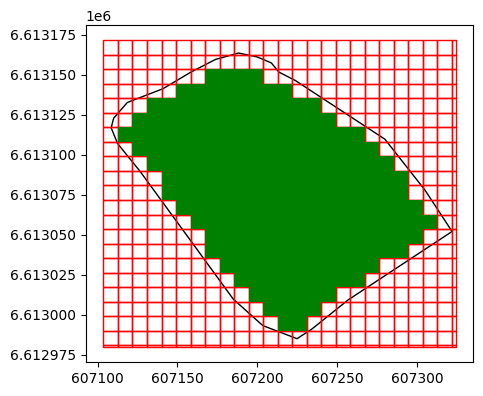

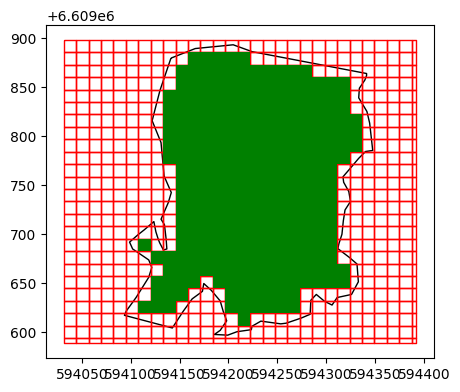

In [ ]:
fig1, ax = plt.subplots(figsize=(5, 5))
footprint_ortho1.plot(ax=ax, edgecolor="black",facecolor="none")
tiles1.plot(ax=ax, edgecolor="red",facecolor="none")
tiles_in1.plot(ax=ax, color="green",facecolor="none")


fig3, ax = plt.subplots(figsize=(5, 5))
footprint_ortho3.plot(ax=ax, edgecolor="black",facecolor="none")
tiles3.plot(ax=ax, edgecolor="red",facecolor="none")
tiles_in3.plot(ax=ax, color="green",facecolor="none")
